# 此筆記介紹 many to one這個種類的 RNN。

所謂many to one即：於多個(many)連續的時間點讀取資訊(例如：$\vec{x}_{t=0},\vec{x}_{t=1},\vec{x}_{t=2}$)，然後來預測接下來單一(one)個時間點的資訊 ($\vec{x}_{t=3}$)。

---

In [1]:
# =========================================================================
# 由於課堂上可能有多人共用同一顆GPU，以下限定使用者只能用計算卡上45%的記憶體。
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95 # 使用45%記憶體
set_session(tf.Session(config=config))
# =========================================================================

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np

import pandas as pd

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN,LSTM,Dense

---

## Case 1: 使用SimpleRNN學習 $[1,0,0,1,0,0,1,0,0,1,0,0,1,....]$

我們接下來會利用 $x_{t=0},x_{t=1},x_{t=2}$ 來預測 $x_{t=3}$。

### 1.1. 先產生用於訓練和測試的資料。

In [4]:
num_samples=200 # 建立兩百個序列樣本
num_train=150   # 其中150個當訓練資料，50個用於測試模型好壞

fake_data=np.array([[0,1,0,0],[1,0,0,1],[0,0,1,0]]) # 每個樣本含四個連續時間：前三個時間的資料會讓網路讀取，後一個時間的資料
                                                    # 是網路的預測目標。
data=np.zeros((num_samples,4),dtype=np.float32 )
for j in range(num_samples):
    rand_idx=np.random.choice(3)
    rand_data=fake_data[rand_idx]
    data[j,:]=rand_data
    
train_x=data[0:num_train,0:3]
test_x=data[num_train:num_samples,0:3]
train_y=data[0:num_train,3].astype(np.int8)
test_y=data[num_train:num_samples,3].astype(np.int8)
print(train_y.shape,train_x.shape,test_y.shape,test_x.shape)

train_x=train_x.reshape((*train_x.shape,1))
test_x=test_x.reshape((*test_x.shape,1))
print(train_y.shape,train_x.shape,test_y.shape,test_x.shape)

(150,) (150, 3) (50,) (50, 3)
(150,) (150, 3, 1) (50,) (50, 3, 1)


### 1.2. 建立並訓練模型，將模型的訓練情形畫出。

In [5]:
hidden_neurons=20

time_dim=3
seq_dim=1

# 建立模型(將SimpleRNN與Dense層依序添加至模型內)。
model = Sequential()  
model.add(SimpleRNN(input_shape=(time_dim,seq_dim), units=hidden_neurons, return_sequences=False))  
model.add(Dense(1,activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

history=model.fit(train_x,train_y,epochs=100,batch_size=32,validation_split=0.3) # 訓練模型。

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
Train on 105 samples, validate on 45 samples
Epoch 1/100
105/105 [==============================] - 1s 12ms/step - loss: 0.7027 - acc: 0.3524 - val_loss: 0.6636 - val_acc: 0.6667
Epoch 2/100
105/105 [==============================] - 0s 729us/step - loss: 0.6500 - acc: 0.6667 - val_loss: 0.6143 - val_acc: 0.6667
Epoch 3/100
105/105 [==============================] - 0s 904us/step - loss: 0.6000 - acc: 0.7143 - val_loss: 0.5663 - val_acc: 1.0000
Epoch 4/100
105/105 [==============================] - 0s 572us/step - loss: 0.5529 - acc: 

105/105 [==============================] - 0s 578us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 1.0000
Epoch 57/100
105/105 [==============================] - 0s 351us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 58/100
105/105 [==============================] - 0s 341us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 59/100
105/105 [==============================] - 0s 347us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 60/100
105/105 [==============================] - 0s 367us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 61/100
105/105 [==============================] - 0s 344us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 62/100
105/105 [==============================] - 0s 349us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 63/100
105/105 [==============================] - 0s 35

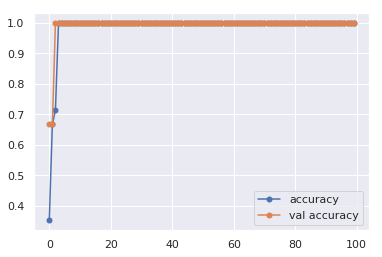

In [6]:
# 畫出模型訓練情形。
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

### 1.3. 丟3個樣本進去做預測。

In [7]:
x_pred=np.array([[0,1,0],[0,0,1],[1,0,0]]).reshape((3,3,1))

#print( model.predict(x_pred) )
#print()
print("predictions=",pd.Series(model.predict(x_pred)[:,0]).apply(lambda x:1 if x>0.5 else 0) \
                                     .values)

predictions= [0 0 1]


這三個樣本事實上機器都看過，故應該會預測的很完美。

---

## Case 2. 輸入時間序列： $x_{t=1},x_{t=2},...,x_{t=n}$，預測 $\vec{x}_{t=n+1}$。

### 2.1. 建立訓練用序列資料：$sin(\pi x)$

In [8]:
x=np.linspace(0,np.pi,100)
y=np.sin(x)

從$sin(x)$序列中抽取$x_{t=1},x_{t=2},...,x_{t=25}$。其中，$x_{t=1},x_{t=2},...,x_{t=20}$將於不同的時間點丟入模型，最後，模型會預測出單一向量$\vec{y} = (x_{t=21},x_{t=22},x_{t=23},...,x_{t=25}$)。

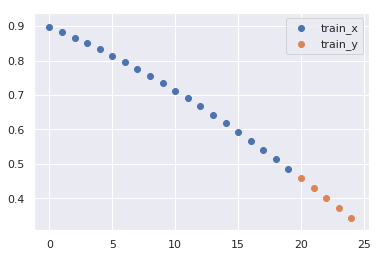

In [9]:
n=20 # 有20個連續的時間點。於每個時間點我們都會輸入資料給模型。
m=5  # 模型將預測的向量維度是5。
num_samples=300 # 300個訓練樣本。

train_x=np.zeros((num_samples,n),dtype=np.float32 )
train_y=np.zeros((num_samples,m),dtype=np.float32 )

for j in range(num_samples):
    rand_num=np.random.choice(100-(n+m))
    train_x[j,:]=y[rand_num:rand_num+n]
    train_y[j,:]=y[rand_num+n:rand_num+n+m]
    
plt.scatter(x=np.arange(20),y=train_x[8,:],label="train_x")
plt.scatter(x=np.arange(20,25),y=train_y[8,:],label="train_y")
plt.legend()
plt.show()

輸入給RNN的資料需要是3D，故我們在這裡轉換```train_x```的shape。

In [10]:
train_x=train_x.reshape(*train_x.shape,1) 

### 2.2. 建立並訓練模型，且畫出模型訓練情形

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 15)                255       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 80        
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________
Train on 210 samples, validate on 90 samples
Epoch 1/200
210/210 [==============================] - 1s 3ms/step - loss: 0.9054 - mean_squared_error: 0.9054 - val_loss: 0.7971 - val_mean_squared_error: 0.7971
Epoch 2/200
210/210 [==============================] - 0s 858us/step - loss: 0.7067 - mean_squared_error: 0.7067 - val_loss: 0.6220 - val_mean_squared_error: 0.6220
Epoch 3/200
210/210 [==============================] - 0s 1ms/step - loss: 0.5527 - mean_squared_error: 0.5527 - val_loss: 0.4911 - val_mean_squared_error: 0.4911
Epoc

Epoch 47/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 48/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 49/200
210/210 [==============================] - 0s 988us/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 50/200
210/210 [==============================] - 0s 895us/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 51/200
210/210 [==============================] - 0s 768us/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 52/200
210/210 [==============================] - 0s 748us/step - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 53

210/210 [==============================] - 0s 745us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 97/200
210/210 [==============================] - 0s 754us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 98/200
210/210 [==============================] - 0s 976us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 99/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 100/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 101/200
210/210 [==============================] - 0s 703us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 102/200
210/2

210/210 [==============================] - 0s 750us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 146/200
210/210 [==============================] - 0s 746us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 147/200
210/210 [==============================] - 0s 668us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 148/200
210/210 [==============================] - 0s 835us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 149/200
210/210 [==============================] - 0s 706us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 150/200
210/210 [==============================] - 0s 699us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 151/20

210/210 [==============================] - 0s 724us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 195/200
210/210 [==============================] - 0s 700us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 196/200
210/210 [==============================] - 0s 750us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 197/200
210/210 [==============================] - 0s 739us/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 198/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 199/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 200/200
21

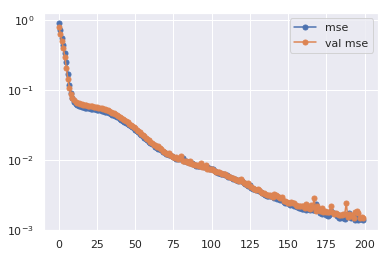

In [11]:
hidden_neurons=15

time_dim=20
seq_dim=1

model = Sequential()  
model.add(SimpleRNN(input_shape=(time_dim,seq_dim), units=hidden_neurons, return_sequences=False))  
model.add(Dense(5,activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

history=model.fit(train_x,train_y,epochs=200,batch_size=32,validation_split=0.3)

plt.yscale('log')
plt.plot(history.history['mean_squared_error'] ,ms=5,marker='o',label='mse')
plt.plot(history.history['val_mean_squared_error'] ,ms=5,marker='o',label='val mse')
plt.legend()
plt.show()

In [12]:
from keras.layers import BatchNormalization

hidden_neurons=15

time_dim=20
seq_dim=1

model = Sequential()  
model.add(SimpleRNN(input_shape=(time_dim,seq_dim), units=hidden_neurons, return_sequences=True))  
#model.add(BatchNormalization())
model.add(SimpleRNN(units=hidden_neurons,
                    recurrent_dropout=0.2,
                    return_sequences=False)) 

model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()



history=model.fit(train_x,train_y,
                  epochs=200,
                  batch_size=32,
                  validation_split=0.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 20, 15)            255       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 15)                465       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 80        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
Train on 210 samples, validate on 90 samples
Epoch 1/200
210/210 [==============================] - 1s 5ms/step - loss: 1.7505 - mean_absolute_error: 1.0667 - val_loss: 1.5386 - val_mean_absolute_error: 1.0230
Epoch 2/200
210/210 [==============================] - 0s 2ms/step - loss: 1.3780 - mean_absolute_error: 0.9649 - val_loss: 1.1596 - val_mean_absolute_error: 0.9046
Epoch 3/200
210/210 [============

Epoch 46/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0260 - mean_absolute_error: 0.1266 - val_loss: 0.0070 - val_mean_absolute_error: 0.0690
Epoch 47/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0242 - mean_absolute_error: 0.1253 - val_loss: 0.0068 - val_mean_absolute_error: 0.0689
Epoch 48/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0205 - mean_absolute_error: 0.1128 - val_loss: 0.0067 - val_mean_absolute_error: 0.0687
Epoch 49/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0226 - mean_absolute_error: 0.1192 - val_loss: 0.0066 - val_mean_absolute_error: 0.0683
Epoch 50/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0230 - mean_absolute_error: 0.1200 - val_loss: 0.0061 - val_mean_absolute_error: 0.0652
Epoch 51/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0179 - mean_absolute_error: 0.1066 - val_loss: 0.0060 - val_mean_absolute_error: 0.0623
Epoc

210/210 [==============================] - 0s 2ms/step - loss: 0.0074 - mean_absolute_error: 0.0682 - val_loss: 0.0019 - val_mean_absolute_error: 0.0354
Epoch 96/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0659 - val_loss: 0.0018 - val_mean_absolute_error: 0.0360
Epoch 97/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0073 - mean_absolute_error: 0.0677 - val_loss: 0.0018 - val_mean_absolute_error: 0.0357
Epoch 98/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_absolute_error: 0.0621 - val_loss: 0.0017 - val_mean_absolute_error: 0.0338
Epoch 99/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0064 - mean_absolute_error: 0.0640 - val_loss: 0.0017 - val_mean_absolute_error: 0.0336
Epoch 100/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0653 - val_loss: 0.0016 - val_mean_absolute_error: 0.0337
Epoch 101/200
21

Epoch 144/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_absolute_error: 0.0458 - val_loss: 9.1486e-04 - val_mean_absolute_error: 0.0247
Epoch 145/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_absolute_error: 0.0444 - val_loss: 8.7803e-04 - val_mean_absolute_error: 0.0243
Epoch 146/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_absolute_error: 0.0481 - val_loss: 8.9835e-04 - val_mean_absolute_error: 0.0244
Epoch 147/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0458 - val_loss: 8.6819e-04 - val_mean_absolute_error: 0.0239
Epoch 148/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_absolute_error: 0.0455 - val_loss: 9.2767e-04 - val_mean_absolute_error: 0.0244
Epoch 149/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 8.8536e-04 - val_me

Epoch 192/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0342 - val_loss: 4.9365e-04 - val_mean_absolute_error: 0.0175
Epoch 193/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0339 - val_loss: 6.4677e-04 - val_mean_absolute_error: 0.0202
Epoch 194/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0343 - val_loss: 4.7297e-04 - val_mean_absolute_error: 0.0172
Epoch 195/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0323 - val_loss: 5.0584e-04 - val_mean_absolute_error: 0.0182
Epoch 196/200
210/210 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0344 - val_loss: 5.2994e-04 - val_mean_absolute_error: 0.0184
Epoch 197/200
210/210 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0349 - val_loss: 5.0083e-04 - val_me

### 2.3. 丟一個隨機樣本進去做預測。

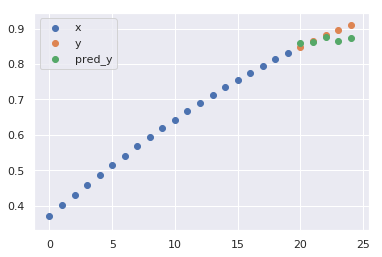

In [13]:
rand_num=np.random.choice(100-(n+m))
test_x=y[rand_num:rand_num+n]
test_y=y[rand_num+n:rand_num+n+m]

y_pred=model.predict( test_x.reshape(1,20,1) )

plt.scatter(x=np.arange(20),y=test_x,label="x")
plt.scatter(x=np.arange(20,25),y=test_y,label="y")
plt.scatter(x=np.arange(20,25),y=y_pred,label="pred_y")
plt.legend()
plt.show()

一般來說，我們不會拿時序資料來預測一個含有時序資訊的向量($\vec{x}_{t=n+1}$)。因為，該時序向量內的資訊可能也有時間上的關聯性。該向量的末端元素可能和該向量內的前端元素比較無關連，卻和前一個元素有極大關聯性。在這個模型下，時序向量內元素間的關聯性將被忽略。

---

## Case 3. 輸入時間序列： $x_{t=1},x_{t=2},...,x_{t=n}$，預測 $x_{t=n+1}$。

記得剛才Case1的序列，其週期為3。以下我們來嘗試週期為15的序列：

### 3.1. 建立訓練用序列資料：$\cos(2\pi b j +\phi)$, where $b=\frac{1}{15}$, $j=0,1,2,...,299$ and $\phi=0$.

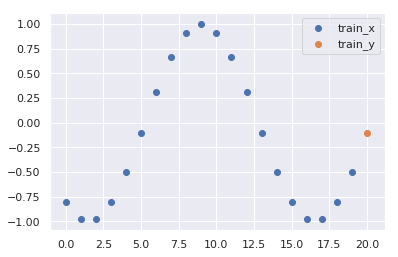

In [14]:
x=np.arange(300)
phi=0
b=1./15.
y=np.cos(2.*np.pi*b*x+phi)

n=20
m=1
num_samples=300

train_x=np.zeros((num_samples,n),dtype=np.float32 )
train_y=np.zeros((num_samples,m),dtype=np.float32 )

for j in range(num_samples):
    rand_num=np.random.choice(100-(n+m))
    train_x[j,:]=y[rand_num:rand_num+n]
    train_y[j,:]=y[rand_num+n:rand_num+n+m]

rand_choice=8
plt.scatter(x=np.arange(20),y=train_x[rand_choice,:],label="train_x")
plt.scatter(x=np.arange(20,21),y=train_y[rand_choice,:],label="train_y")
plt.legend()
plt.show()

train_x=train_x.reshape(*train_x.shape,1)

### 3.2. 建立並訓練模型，且畫出模型訓練情形

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 15)                255       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 16        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________
Train on 210 samples, validate on 90 samples
Epoch 1/200
210/210 [==============================] - 1s 4ms/step - loss: 0.3050 - mean_squared_error: 0.3050 - val_loss: 0.2202 - val_mean_squared_error: 0.2202
Epoch 2/200
210/210 [==============================] - 0s 717us/step - loss: 0.1738 - mean_squared_error: 0.1738 - val_loss: 0.1406 - val_mean_squared_error: 0.1406
Epoch 3/200
210/210 [==============================] - 0s 661us/step - loss: 0.1097 - mean_squared_error: 0.1097 - val_loss: 0.0883 - val_mean_squared_error: 0.0883
Ep

Epoch 45/200
210/210 [==============================] - 0s 740us/step - loss: 4.6187e-04 - mean_squared_error: 4.6187e-04 - val_loss: 3.9437e-04 - val_mean_squared_error: 3.9437e-04
Epoch 46/200
210/210 [==============================] - 0s 712us/step - loss: 4.0816e-04 - mean_squared_error: 4.0816e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 47/200
210/210 [==============================] - 0s 757us/step - loss: 6.3652e-04 - mean_squared_error: 6.3652e-04 - val_loss: 6.8665e-04 - val_mean_squared_error: 6.8665e-04
Epoch 48/200
210/210 [==============================] - 0s 721us/step - loss: 6.1748e-04 - mean_squared_error: 6.1748e-04 - val_loss: 3.9903e-04 - val_mean_squared_error: 3.9903e-04
Epoch 49/200
210/210 [==============================] - 0s 676us/step - loss: 3.4026e-04 - mean_squared_error: 3.4026e-04 - val_loss: 7.2218e-04 - val_mean_squared_error: 7.2218e-04
Epoch 50/200
210/210 [==============================] - 0s 682us/step - loss: 6.2703e-04 - mean_sq

210/210 [==============================] - 0s 744us/step - loss: 9.8529e-05 - mean_squared_error: 9.8529e-05 - val_loss: 1.5439e-04 - val_mean_squared_error: 1.5439e-04
Epoch 91/200
210/210 [==============================] - 0s 707us/step - loss: 3.5293e-04 - mean_squared_error: 3.5293e-04 - val_loss: 1.0675e-04 - val_mean_squared_error: 1.0675e-04
Epoch 92/200
210/210 [==============================] - 0s 726us/step - loss: 9.1221e-05 - mean_squared_error: 9.1221e-05 - val_loss: 1.3742e-04 - val_mean_squared_error: 1.3742e-04
Epoch 93/200
210/210 [==============================] - 0s 688us/step - loss: 3.8575e-04 - mean_squared_error: 3.8575e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 94/200
210/210 [==============================] - 0s 699us/step - loss: 2.8076e-04 - mean_squared_error: 2.8076e-04 - val_loss: 1.0922e-04 - val_mean_squared_error: 1.0922e-04
Epoch 95/200
210/210 [==============================] - 0s 698us/step - loss: 1.1323e-04 - mean_squared_error: 

210/210 [==============================] - 0s 711us/step - loss: 1.1027e-04 - mean_squared_error: 1.1027e-04 - val_loss: 1.4736e-04 - val_mean_squared_error: 1.4736e-04
Epoch 136/200
210/210 [==============================] - 0s 892us/step - loss: 4.5506e-04 - mean_squared_error: 4.5506e-04 - val_loss: 7.0460e-05 - val_mean_squared_error: 7.0460e-05
Epoch 137/200
210/210 [==============================] - 0s 1ms/step - loss: 5.6419e-05 - mean_squared_error: 5.6419e-05 - val_loss: 1.3572e-04 - val_mean_squared_error: 1.3572e-04
Epoch 138/200
210/210 [==============================] - 0s 823us/step - loss: 2.6841e-04 - mean_squared_error: 2.6841e-04 - val_loss: 9.2366e-05 - val_mean_squared_error: 9.2366e-05
Epoch 139/200
210/210 [==============================] - 0s 726us/step - loss: 6.7026e-05 - mean_squared_error: 6.7026e-05 - val_loss: 3.5246e-04 - val_mean_squared_error: 3.5246e-04
Epoch 140/200
210/210 [==============================] - 0s 763us/step - loss: 3.7378e-04 - mean_squa

Epoch 180/200
210/210 [==============================] - 0s 629us/step - loss: 2.3738e-04 - mean_squared_error: 2.3738e-04 - val_loss: 3.1909e-04 - val_mean_squared_error: 3.1909e-04
Epoch 181/200
210/210 [==============================] - 0s 642us/step - loss: 1.1530e-04 - mean_squared_error: 1.1530e-04 - val_loss: 1.9124e-04 - val_mean_squared_error: 1.9124e-04
Epoch 182/200
210/210 [==============================] - 0s 602us/step - loss: 2.5360e-04 - mean_squared_error: 2.5360e-04 - val_loss: 1.9825e-04 - val_mean_squared_error: 1.9825e-04
Epoch 183/200
210/210 [==============================] - 0s 616us/step - loss: 7.7607e-05 - mean_squared_error: 7.7607e-05 - val_loss: 7.1205e-05 - val_mean_squared_error: 7.1205e-05
Epoch 184/200
210/210 [==============================] - 0s 623us/step - loss: 2.2245e-04 - mean_squared_error: 2.2245e-04 - val_loss: 4.4861e-04 - val_mean_squared_error: 4.4861e-04
Epoch 185/200
210/210 [==============================] - 0s 660us/step - loss: 1.0487

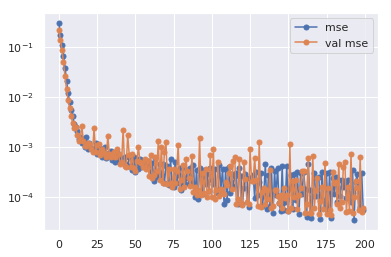

In [15]:
hidden_neurons=15

time_dim=20
seq_dim=1

model = Sequential()  
model.add(SimpleRNN(input_shape=(time_dim,seq_dim), units=hidden_neurons, return_sequences=False))  
model.add(Dense(1,activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
model.summary()

history=model.fit(train_x,train_y,epochs=200,batch_size=32,validation_split=0.3)

plt.yscale('log')
plt.plot(history.history['mean_squared_error'] ,ms=5,marker='o',label='mse')
plt.plot(history.history['val_mean_squared_error'] ,ms=5,marker='o',label='val mse')
plt.legend()
plt.show()

### 3.3. 丟入64個隨機樣本進去做預測。抽看其中一個樣本的預測結果。

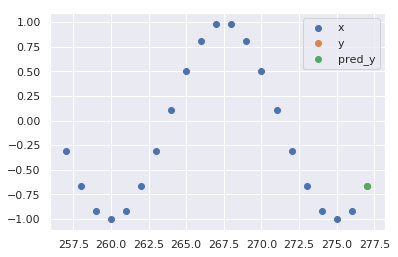

In [16]:
x=np.arange(300)
phi=np.pi/3.
b=1./15.
y=np.cos(2.*np.pi*b*x+phi)


test_samples=64

tests_x=np.zeros( (test_samples,n)  )
tests_y=np.zeros( (test_samples,1)  )

rand_nums=np.zeros(test_samples)
for j in range(test_samples):
    rand_num=np.random.choice(300-(n+m))
    tests_x[j,:] = y[rand_num:rand_num+n]
    tests_y[j,:] = y[rand_num+n:rand_num+n+m]
    rand_nums[j]=rand_num
    
tests_x=tests_x.reshape(test_samples,20,1)
y_pred=model.predict( tests_x )

choice_idx=5

plt.scatter(x=np.arange(rand_nums[choice_idx],rand_nums[choice_idx]+n),y=tests_x[choice_idx],label="x")
plt.scatter(x=np.arange(rand_nums[choice_idx]+n,rand_nums[choice_idx]+n+m),y=tests_y[choice_idx],label="y")
plt.scatter(x=np.arange(rand_nums[choice_idx]+n,rand_nums[choice_idx]+n+m),y=y_pred[choice_idx],label="pred_y")
plt.legend()
plt.show()

### 3.4. 看數個預測結果是否貼合真實資料。

(0, 100)

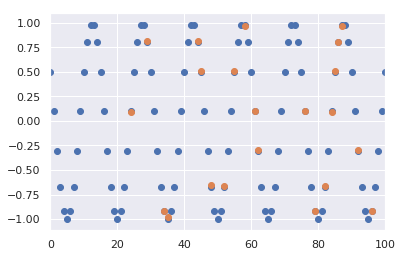

In [17]:
pred_y_xy=np.zeros((2,m*test_samples))

for j in range(test_samples):
    pred_y_xy[0,m*j:m*(j+1)]=np.arange(rand_nums[j]+n,rand_nums[j]+n+m)
    pred_y_xy[1,m*j:m*(j+1)]=y_pred[j].T
    
plt.scatter(x,y)

plt.scatter(x=pred_y_xy[0,:],y=pred_y_xy[1,:])
plt.xlim((0,100))

---

## Case 4. 輸入時間序列： $x_{t=1},x_{t=2},...,x_{t=n}$，預測 $x_{t=n+1}$。

以下我們來嘗試一個週期為無限大，卻彷彿有週期的序列：

### 4.1. 建立訓練用序列資料：$\cos(2\pi b j +\phi)$, where $b=\frac{1+\sqrt{5}}{2}$, $j=0,1,2,...,299$ and $\phi=0$.

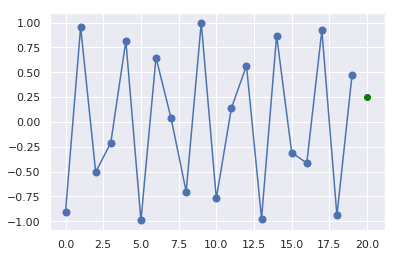

In [18]:
# 建立該序列
x=np.arange(1000)
phi=0.
b=(1.+np.sqrt(5.))/2.
y=np.cos(2.*np.pi*b*x+phi)

# 決定如何建立訓練資料
n=20            # 訓練資料共20個時間點
m=1             # 我們要來預測第21個時間點的資訊應為何。第21個時間點的向量維度應為1。
num_samples=500 # 訓練資料五百筆

# 製作訓練資料
train_x=np.zeros((num_samples,n),dtype=np.float32 )
train_y=np.zeros((num_samples,m),dtype=np.float32 )
for j in range(num_samples):
    rand_num=np.random.choice(100-(n+m))
    train_x[j,:]=y[rand_num:rand_num+n]
    train_y[j,:]=y[rand_num+n:rand_num+n+m]

# 抽一個訓練用的樣本畫出來看看
rand_choice=8
plt.plot(np.arange(n),train_x[rand_choice,:],ms=7,marker='o',label="train_x")
plt.scatter(x=np.arange(n,n+1),y=train_y[rand_choice,:],label="train_y",color='green')
#plt.legend()
plt.show()

# train_x需轉為3D，方能做為SimpleRNN層的輸入
train_x=train_x.reshape(*train_x.shape,1) 

將局部的$\cos(2\pi b j +\phi)$序列畫出來看一下：

(0, 50)

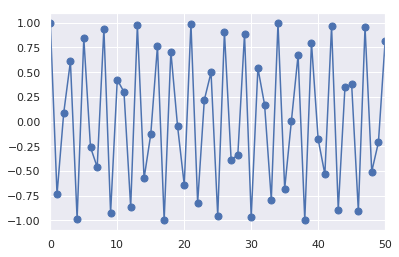

In [19]:
plt.plot(x,y,ms=7,marker='o')
plt.xlim(0,50)

### 4.2. 建立並訓練模型，且畫出模型訓練情形

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________
Train on 400 samples, validate on 100 samples
Epoch 1/200
400/400 [==============================] - 1s 2ms/step - loss: 0.1518 - mean_squared_error: 0.1518 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 2/200
400/400 [==============================] - 0s 351us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 3/200
400/400 [==============================] - 0s 373us/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0146 - val_mean_squared_error: 0.01

400/400 [==============================] - 0s 334us/step - loss: 2.3501e-04 - mean_squared_error: 2.3501e-04 - val_loss: 2.4753e-04 - val_mean_squared_error: 2.4753e-04
Epoch 44/200
400/400 [==============================] - 0s 341us/step - loss: 2.2373e-04 - mean_squared_error: 2.2373e-04 - val_loss: 2.2125e-04 - val_mean_squared_error: 2.2125e-04
Epoch 45/200
400/400 [==============================] - 0s 329us/step - loss: 2.2243e-04 - mean_squared_error: 2.2243e-04 - val_loss: 1.8452e-04 - val_mean_squared_error: 1.8452e-04
Epoch 46/200
400/400 [==============================] - 0s 308us/step - loss: 2.2123e-04 - mean_squared_error: 2.2123e-04 - val_loss: 2.0497e-04 - val_mean_squared_error: 2.0497e-04
Epoch 47/200
400/400 [==============================] - 0s 307us/step - loss: 2.0429e-04 - mean_squared_error: 2.0429e-04 - val_loss: 1.7835e-04 - val_mean_squared_error: 1.7835e-04
Epoch 48/200
400/400 [==============================] - 0s 389us/step - loss: 1.8935e-04 - mean_squared

400/400 [==============================] - 0s 331us/step - loss: 7.7804e-05 - mean_squared_error: 7.7804e-05 - val_loss: 6.5099e-05 - val_mean_squared_error: 6.5099e-05
Epoch 89/200
400/400 [==============================] - 0s 362us/step - loss: 7.7926e-05 - mean_squared_error: 7.7926e-05 - val_loss: 6.3056e-05 - val_mean_squared_error: 6.3056e-05
Epoch 90/200
400/400 [==============================] - 0s 317us/step - loss: 7.6720e-05 - mean_squared_error: 7.6720e-05 - val_loss: 6.2317e-05 - val_mean_squared_error: 6.2317e-05
Epoch 91/200
400/400 [==============================] - 0s 329us/step - loss: 7.5747e-05 - mean_squared_error: 7.5747e-05 - val_loss: 6.1860e-05 - val_mean_squared_error: 6.1860e-05
Epoch 92/200
400/400 [==============================] - 0s 348us/step - loss: 7.5225e-05 - mean_squared_error: 7.5225e-05 - val_loss: 7.0305e-05 - val_mean_squared_error: 7.0305e-05
Epoch 93/200
400/400 [==============================] - 0s 323us/step - loss: 8.1936e-05 - mean_squared

Epoch 133/200
400/400 [==============================] - 0s 319us/step - loss: 6.0577e-05 - mean_squared_error: 6.0577e-05 - val_loss: 4.9628e-05 - val_mean_squared_error: 4.9628e-05
Epoch 134/200
400/400 [==============================] - 0s 335us/step - loss: 5.9293e-05 - mean_squared_error: 5.9293e-05 - val_loss: 5.2285e-05 - val_mean_squared_error: 5.2285e-05
Epoch 135/200
400/400 [==============================] - 0s 321us/step - loss: 6.0306e-05 - mean_squared_error: 6.0306e-05 - val_loss: 5.4839e-05 - val_mean_squared_error: 5.4839e-05
Epoch 136/200
400/400 [==============================] - 0s 322us/step - loss: 6.3991e-05 - mean_squared_error: 6.3991e-05 - val_loss: 5.1811e-05 - val_mean_squared_error: 5.1811e-05
Epoch 137/200
400/400 [==============================] - 0s 360us/step - loss: 5.9242e-05 - mean_squared_error: 5.9242e-05 - val_loss: 4.7658e-05 - val_mean_squared_error: 4.7658e-05
Epoch 138/200
400/400 [==============================] - 0s 414us/step - loss: 6.0124

Epoch 178/200
400/400 [==============================] - 0s 355us/step - loss: 5.0787e-05 - mean_squared_error: 5.0787e-05 - val_loss: 6.3407e-05 - val_mean_squared_error: 6.3407e-05
Epoch 179/200
400/400 [==============================] - 0s 537us/step - loss: 6.2460e-05 - mean_squared_error: 6.2460e-05 - val_loss: 6.1193e-05 - val_mean_squared_error: 6.1193e-05
Epoch 180/200
400/400 [==============================] - 0s 610us/step - loss: 6.7397e-05 - mean_squared_error: 6.7397e-05 - val_loss: 1.4662e-04 - val_mean_squared_error: 1.4662e-04
Epoch 181/200
400/400 [==============================] - 0s 480us/step - loss: 1.1098e-04 - mean_squared_error: 1.1098e-04 - val_loss: 1.0154e-04 - val_mean_squared_error: 1.0154e-04
Epoch 182/200
400/400 [==============================] - 0s 367us/step - loss: 7.7162e-05 - mean_squared_error: 7.7162e-05 - val_loss: 1.1714e-04 - val_mean_squared_error: 1.1714e-04
Epoch 183/200
400/400 [==============================] - 0s 411us/step - loss: 7.2644

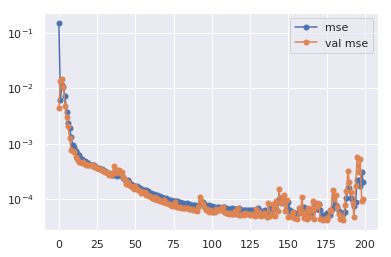

In [20]:
hidden_neurons=50

time_dim=20
seq_dim=1

model = Sequential()  
model.add(SimpleRNN(input_shape=(time_dim,seq_dim), units=hidden_neurons, return_sequences=False))  
model.add(Dense(1,activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

history=model.fit(train_x,train_y,epochs=200,batch_size=64,validation_split=0.2)

plt.yscale('log')
plt.plot(history.history['mean_squared_error'] ,ms=5,marker='o',label='mse')
plt.plot(history.history['val_mean_squared_error'] ,ms=5,marker='o',label='val mse')
plt.legend()
plt.show()

### 4.3. 丟一個隨機樣本進去做預測。

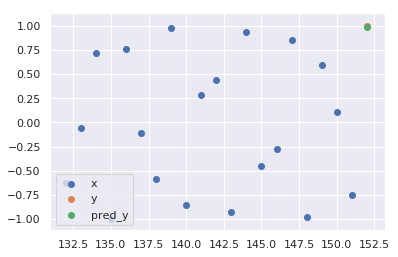

In [21]:
x=np.arange(1000)
phi=0.123*np.pi
b=(1.+np.sqrt(5.))/2.
y=np.cos(2.*np.pi*b*x+phi)

test_samples=64

tests_x=np.zeros( (test_samples,n)  )
tests_y=np.zeros( (test_samples,1)  )

rand_nums=np.zeros(test_samples)
for j in range(test_samples):
    rand_num=np.random.choice(300-(n+m))
    tests_x[j,:] = y[rand_num:rand_num+n]
    tests_y[j,:] = y[rand_num+n:rand_num+n+m]
    rand_nums[j]=rand_num

tests_x=tests_x.reshape(test_samples,20,1)
y_pred=model.predict( tests_x )

choice_idx=5
plt.scatter(x=np.arange(rand_nums[choice_idx],rand_nums[choice_idx]+n),y=tests_x[choice_idx],label="x")
plt.scatter(x=np.arange(rand_nums[choice_idx]+n,rand_nums[choice_idx]+n+m),y=tests_y[choice_idx],label="y")
plt.scatter(x=np.arange(rand_nums[choice_idx]+n,rand_nums[choice_idx]+n+m),y=y_pred[choice_idx],label="pred_y")
plt.legend(loc='lower left')
plt.show()

雖然資料可能不具有週期性，但，只要資料彷彿有某種規律，機器就可以學習那個規律。